# 사람이 말하는 단어를 인공지능 모델로 구분해보기

## 학습목표

* Audio 형태의 데이터를 다루는 방법에 대해서 알아보기

* Wav 파일의 형태와 원리를 이해하기

* 오디오데이터를 다른 다양한 형태로 변형시켜보기

* 차원이 다른 데이터에 사용가능한 classification 모델 직접 제작해보기

## 음성과 오디오 데이터

### 파동으로서의 소리

소리는 진동으로 인한 공기의 압축을 이야기하며, 압축이 얼마나됐느냐는 파동(Wave)로 나타낼 수 있다.

* 소리에서 얻을 수 있는 물리량  

-진폭(Amplitude) → 강도(Intensity)  
-주파수(Frequency) →소리의 높낮이(Pitch)  
-위상(Phase) → 음색  

## 오디오 데이터의 디지털화

In [1]:
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

In [3]:
# 아날로그 신호의 Sampling
import numpy as np
import matplotlib.pyplot as plt

def single_tone(frequecy, sampling_rate=16000, duration=1):
    t = np.linspace(0, duration, int(sampling_rate))
    y = np.sin(2 * np.pi * frequecy * t)
    return y

y = single_tone(400)

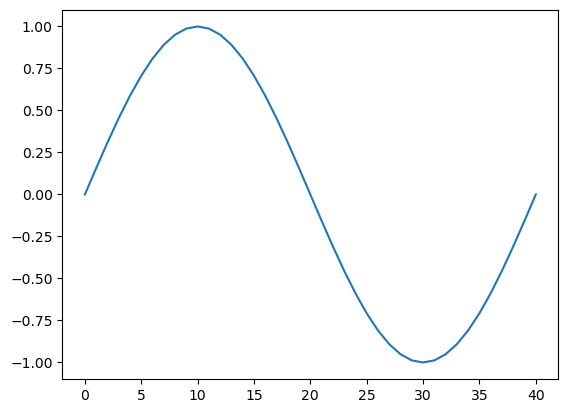

In [4]:
# 시각화
plt.plot(y[:41])
plt.show()

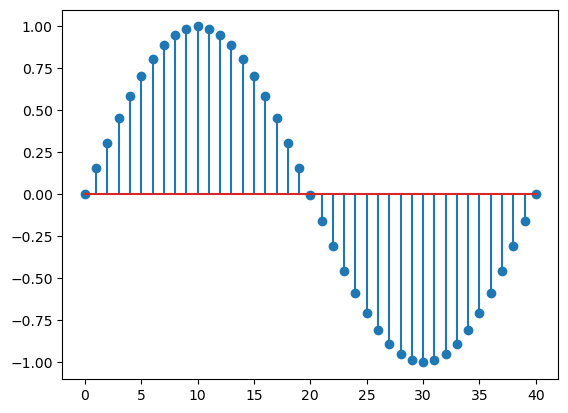

In [5]:
# 시각화
plt.stem(y[:41])
plt.show()

일반적으로 사용하는 주파수 영역대는 16kHz, 44.1kHz이며, 16kHz는 보통 Speech에서 많이 사용되고, 44.1kHz는 Music에서 많이 사용한다.

나이키스트-섀넌 표본화에 따르면 Sampling rate는 최대 주파수의 2배 이상을 표본화 주파수로 사용해야 aliasing을 방지할 수 있다고 한다.  

연속적인 아날로그 신호는 표본화(Sampling), 양자화(Quantizing), 부호화(Encoding)을 거쳐 이진 디지털 신호(Binary Digital Signal)로 변환시켜 인식한다.



## Wave Data 분석

* Bits per Sample(bps)

-샘플 하나마다의 소리의 세기를 몇 비트로 저장했는지 나타내는 단위  
-값이 커질수록 세기를 정확하게 저장 가능  
-16bit의 경우, 2^16인 65,536단계로 표현 가능

* Sampling Frequency

-소리로부터 초당 샘플링한 횟수를 의미  
-샘플링은 나이퀴스트 샘플링 룰에 따라서 복원해야 할 신호 주파수 2배 이상으로 샘플링  
-가청 주파수 20 ~ 24kHz를 복원하기 위해 사용하며, 음원에서는 44.1kHz를 많이 사용

* Channel

-각 채널별로 샘플링된 데이터가 따로 저장  
-2채널은 왼쪽(L)과 오른쪽(R), 1채널은 왼쪽(L) 데이터만 있으며 재생시엔 LR 동시출력

## 데이터셋 살펴보기

npz파일로 이뤄진 데이터이며, 각각 데이터는 "wav_vals", "label_vals"로 저장되어 있다.

In [6]:
# 데이터 불러오기
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("Wave data shape :",speech_data["wav_vals"].shape)
print("Label data shape :", speech_data["label_vals"].shape)

Wave data shape : (50620, 8000)
Label data shape : (50620, 1)


In [7]:
# 데이터 확인
import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택됨)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num :", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape :", data.shape)
print("label :", speech_data["label_vals"][rand])
ipd.Audio(data, rate=sr)

rand num : 36753
Wave data shape : (8000,)
label : ['stop']


## Train/Test 데이터셋 구성하기

### Label Data 처리

In [8]:
# 구분해야 할 Data Label list
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print("LABEL :", label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print("Indexed LABEL :", new_label_value)

# Label Data indexing
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

LABEL : ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL : {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


array([ 3,  3,  3, ..., 11, 11, 11])

### 데이터 분리

In [9]:
# 사이킷런의 split 함수를 이용하여 데이터 분리
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])

[[ 1.5292076e-03  2.9736303e-03  3.6546460e-03 ...  1.1288727e-03
   8.9064991e-04  1.6433508e-03]
 [-2.9318130e-03 -3.5311615e-03 -3.4212696e-03 ...  3.5169283e-03
   3.4868121e-03 -4.0697758e-03]
 [ 3.7184351e-03  5.0866324e-03 -3.6839722e-04 ...  6.1819004e-04
  -4.4563785e-07 -3.6110990e-03]
 ...
 [ 1.0507535e-04 -8.2842214e-04 -1.5759577e-04 ...  4.7356062e-04
  -2.1565445e-04 -5.9429777e-04]
 [ 7.5585413e-05  2.4761737e-04  1.4376457e-04 ... -2.1458061e-04
  -1.2703879e-04 -4.2919044e-05]
 [-1.6386550e-03  9.9397766e-05  3.9522699e-03 ... -7.8058377e-04
  -6.5404997e-04 -8.8088331e-04]]


In [10]:
# 데이터셋 확인
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

# 하이퍼파라미터 세팅
batch_size = 32
max_epochs = 10

# save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'
checkpoint_dir

train data :  (45558, 8000, 1)
train labels :  (45558,)
test data :  (5062, 8000, 1)
test labels :  (5062,)


'/home/jin/aiffel/speech_recognition/models/wav'

## 데이터 셋팅

tf.data.Dataset을 이용해서 데이터셋을 구성한다.

tf.data.Dataset.from_tensor_slices 함수에 return 받기 원하는 데이터를 튜플(data, label) 형태로 넣어서 사용할 수 있다.

map함수는 dataset이 데이터를 불러올 때 마다 동작시킬 데이터 전처리 함수를 매핑해준다.

In [11]:
# One-hot Encoding
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

# Dataset 함수 구성
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>


## Wave classification 모델 구현

### 모델 설계

audio는 1차원 데이터이기 때문에 데이터 형식에 맞게 모델을 구성해주어야 한다

In [12]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8000, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8000, 32)          9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4000, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4000, 64)          18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4000, 64)          36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2000, 64)          0     

### loss function

정답 label의 class가 12개이기 때문에 해당 class를 구분하기 위해서는 multi-class classification이 필요하며, 이를 수행하기 위한 Loss function으로는 Categorical Cross-Entropy loss function을 사용한다.

In [13]:
optimizer=tf.keras.optimizers.Adam(1e-4)
"""
from_logit=True : softmax 함수를 거치면 from_logits = False(default값),
그렇지 않으면 from_logits = True
"""
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

### 모델 훈련

callback 함수를 이용하여 학습 중간중간에 원하는 동작을 하도록 설정할 수 있다.  
(ModelCheckpoint) callback은 학습을 진행하면서 fit 함수의 다양한 인자를 지정해 모니터링하며 동작하게 설정할 수 있다.  
현재 모델은 validation loss를 모니터, loss가 낮아지면 모델파라미터 저장하게 구성되어 있음

In [14]:
# callback 설정
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir, save_weights_only=True,
                                                 monitor='val_loss', mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [15]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Memory growth must be set before GPUs have been initialized
#         print(e)

In [16]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

In [17]:
# 모델 훈련
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                           steps_per_epoch=len(train_wav)//batch_size, 
                           validation_data=test_dataset,
                           validation_steps=len(test_wav)//batch_size,
                           callbacks=[cp_callback])

Epoch 1/10
1423/1423 [==============================] - 198s 132ms/step - loss: 1.8187 - accuracy: 0.3774 - val_loss: 0.8964 - val_accuracy: 0.7116

Epoch 00001: val_loss improved from inf to 0.89639, saving model to /home/jin/aiffel/speech_recognition/models/wav
Epoch 2/10
1423/1423 [==============================] - 188s 132ms/step - loss: 0.8970 - accuracy: 0.7208 - val_loss: 0.7072 - val_accuracy: 0.7672

Epoch 00002: val_loss improved from 0.89639 to 0.70717, saving model to /home/jin/aiffel/speech_recognition/models/wav
Epoch 3/10
1423/1423 [==============================] - 188s 132ms/step - loss: 0.6554 - accuracy: 0.8016 - val_loss: 0.5760 - val_accuracy: 0.8145

Epoch 00003: val_loss improved from 0.70717 to 0.57600, saving model to /home/jin/aiffel/speech_recognition/models/wav
Epoch 4/10
1423/1423 [==============================] - 189s 133ms/step - loss: 0.4712 - accuracy: 0.8580 - val_loss: 0.4686 - val_accuracy: 0.8501

Epoch 00004: val_loss improved from 0.57600 to 0.46

### 결과 확인

In [18]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

In [19]:
epochs_range = range(len(acc))

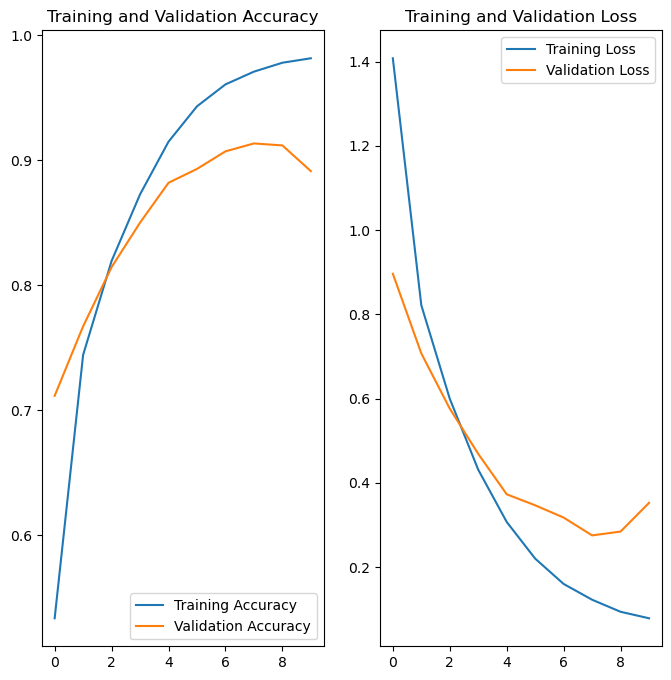

In [20]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**training loss와 validation loss의 차이가 커지는 경우에는 overfitting이 일어나는 것이기 때문에 주의**

### 모델 평가

In [21]:
# checkpoint callback 함수에서 저장한 weight 불러오기
model_wav.load_weights(checkpoint_dir)

In [22]:
# test 데이터와 비교
results = model_wav.evaluate(test_dataset)

159/159 [==============================] - 10s 61ms/step - loss: 0.2749 - accuracy: 0.9133


In [23]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value: 0.275
accuracy value: 91.3275%


### 모델 테스트

Test data에서 직접 들어보고 예측이 맞는지 확인

In [24]:
# 예측 데이터
inv_label_value = {v:k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ =  model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  unknown


In [25]:
# 실제 데이터가 맞는지 확인
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: "+str(inv_label_value[np.argmax(y_pred_)])+'(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')    
    

y_pred: unknown(Correct!)


In [ ]:
stop

## Skip Connection model

이미지 처리에서 Skip-Connection을 활용한 모델들이 훨씬 안정적으로 높은 성능을 낸다고 한다. 음성처리 모델에도 똑같이 적용할 수 있을까?  
skip_connection은 concat을 이용한 방식으로 구현된다.

tf.concat([#layer output tensor, layer output tensor#], axis=#)

In [26]:
input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1) # 마지막 차원이 선택됨
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

In [27]:
model_wav_skip.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 8000, 32)     320         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 8000, 32)     9248        conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 4000, 32)     0           conv1d_11[0][0]                  
____________________________________________________________________________________________

In [28]:
# Optimization
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [29]:
# checkpoint
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [30]:
# 모델 학습
batch_size = 32 # 메모리 주의
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
1423/1423 [==============================] - 228s 158ms/step - loss: 1.6311 - accuracy: 0.4591 - val_loss: 0.7855 - val_accuracy: 0.7516

Epoch 00001: val_loss improved from inf to 0.78545, saving model to /home/jin/aiffel/speech_recognition/models/wav_skip
Epoch 2/10
1423/1423 [==============================] - 223s 157ms/step - loss: 0.7403 - accuracy: 0.7767 - val_loss: 0.5678 - val_accuracy: 0.8305

Epoch 00002: val_loss improved from 0.78545 to 0.56781, saving model to /home/jin/aiffel/speech_recognition/models/wav_skip
Epoch 3/10
1423/1423 [==============================] - 223s 157ms/step - loss: 0.4203 - accuracy: 0.8845 - val_loss: 0.3619 - val_accuracy: 0.8940

Epoch 00003: val_loss improved from 0.56781 to 0.36194, saving model to /home/jin/aiffel/speech_recognition/models/wav_skip
Epoch 4/10
1423/1423 [==============================] - 223s 157ms/step - loss: 0.2217 - accuracy: 0.9469 - val_loss: 0.3061 - val_accuracy: 0.9114

Epoch 00004: val_loss improved from 

In [31]:
# 시각화
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

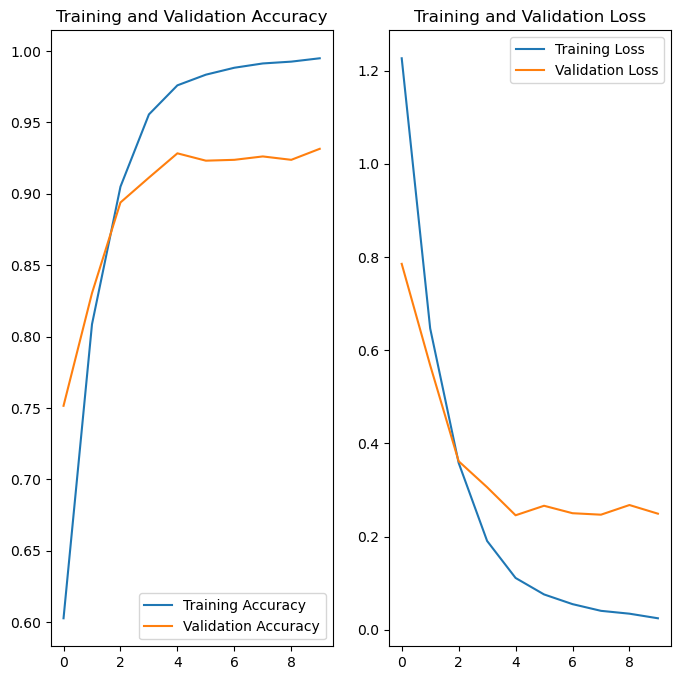

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
# 모델 평가
model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

159/159 [==============================] - 8s 49ms/step - loss: 0.2456 - accuracy: 0.9285


In [34]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value: 0.246
accuracy value: 92.8487%


In [35]:
# 실제 확인 테스트
inv_label_value = {v:k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)



label :  off


In [36]:
# 예측 결과
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

y_pred: off(Correct!)
